In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras import layers
from keras.initializers import Constant


     |████████████████████████████████| 15.7MB 2.4MB/s 
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/minor2/twitter2/'

/content/drive/My Drive/minor2/twitter2


In [4]:
df1=pd.read_excel('twitter2_data.xlsx')
df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)
df1.head()

,_id,text,label
0,5e4ce1ac5ca387d4c86d31d9,RT @fairbairn77: I'm not sexist or anything bu...,1
1,5e4cebeb5ca387d4c86d4ec1,RT @colonelkickhead: Apparently walking a catw...,0
2,5e4d048f5ca387d4c86d8084,RT @athenahollow: @freebsdgirl He REALLY picke...,0
3,5e4ce2125ca387d4c86d32a6,@JohnJohnisKilla Call me sexist or whatever it...,1
4,5e4ceb135ca387d4c86d4cd1,I don't understand mean girls. And certainly n...,0


In [5]:
np.mean(df1['label'])

0.2634443317037174

In [0]:
text=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [8]:
%%time
text = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 1min 52s, sys: 842 ms, total: 1min 53s
Wall time: 1min 54s


In [0]:
text2=[]
for i in text:
    lst=i.split()
    text2.append(lst)

In [10]:
exdf=pd.DataFrame()
exdf['text']=["hello my \n is ./.,is tushit's \t @344$%% what are you D.R   running  doing?? please HELP!!"]
clean_ex = TextPreprocessor(n_jobs=-1).transform(exdf['text'])
print(clean_ex[0])

hello tushit @344$%% DR run HELP


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(text2) 
sequences = tokenizer.texts_to_sequences(text2)
word_index = tokenizer.word_index
print('Found %s unique tokens.',len(word_index))
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(s.split()) for s in text])
tweets_pad = pad_sequences(sequences, maxlen=maxlen)
print(tweets_pad.shape) 


Found %s unique tokens. 14886
(10841, 28)


In [0]:
df3=pd.concat([pd.DataFrame(text),pd.DataFrame(tweets_pad)],axis=1)

In [13]:
"""
labels = np.asarray(labels)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 7000  # We will be training on 10K samples
#validation_samples = 4000  # We will be validating on 10000 samples

# Split data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:]
y_val = labels[training_samples:]"""

'\nlabels = np.asarray(labels)\n\n# Shuffle data\nindices = np.arange(data.shape[0])\nnp.random.shuffle(indices)\ndata = data[indices]\nlabels = labels[indices]\n\ntraining_samples = 7000  # We will be training on 10K samples\n#validation_samples = 4000  # We will be validating on 10000 samples\n\n# Split data\nx_train = data[:training_samples]\ny_train = labels[:training_samples]\nx_val = data[training_samples:]\ny_val = labels[training_samples:]'

In [14]:

#glove_dir = '../input/glove-global-vectors-for-word-representation' # This is the folder with the dataset

print('Loading word vectors')
embeddings_index = {} # We create a dictionary of word -> embedding
f = open('/content/drive/My Drive/minor2/twitter2/glove.6B.100d.txt','r') # Open file

# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
for line in tqdm(f):
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    values = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = values # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Loading word vectors


400001it [00:14, 26877.58it/s]

Found 400001 word vectors.


In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.0044520576, 0.40815717)

In [0]:
embedding_dim = 100
word_index = tokenizer.word_index
num_words = len(word_index)+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix.shape

(14887, 100)

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

In [19]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            weights = [embedding_matrix],
                            input_length = maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,552,957
Trainable params: 64,257
Non-trainable params: 1,488,700
_________________________________________________________________


In [20]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=100))
model.add(Dropout(.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,569,201
Trainable params: 80,501
Non-trainable params: 1,488,700
_________________________________________________________________


In [21]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,549,101
Trainable params: 60,401
Non-trainable params: 1,488,700
_________________________________________________________________


In [22]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(layers.Dense(10, activation='sigmoid'))
#model.add(GRU(units=100,dropout=0.2 , recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2800)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                28010     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,516,721
Trainable params: 28,021
Non-trainable params: 1,488,700
_________________________________________________________________


In [23]:
model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = maxlen,
                            trainable=False)
model.add(embedding_layer)
#model.add(Flatten())
model.add(SimpleRNN(32, dropout=.2, recurrent_dropout=.2))
model.add(layers.Dense(10, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 1,493,297
Trainable params: 4,597
Non-trainable params: 1,488,700
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_testing ,y_train, y_testing = train_test_split(df3, labels, test_size = 0.60, random_state = 1)

In [0]:
X_test, X_val ,y_test, y_val = train_test_split(X_testing, y_testing, test_size = 0.50, random_state = 0)

In [23]:
print('Training.....')
history=model.fit(X_train.iloc[:,1:], y_train, batch_size=64,epochs=10,validation_data=(X_val.iloc[:,1:],y_val),verbose=True)

Training.....


Train on 4336 samples, validate on 3253 samples
Epoch 1/10
4336/4336 [==============================] - 5s 1ms/step - loss: 0.5007 - acc: 0.7740 - val_loss: 0.4325 - val_acc: 0.8196
Epoch 2/10
4336/4336 [==============================] - 4s 820us/step - loss: 0.4123 - acc: 0.8305 - val_loss: 0.4075 - val_acc: 0.8214
Epoch 3/10
4336/4336 [==============================] - 4s 811us/step - loss: 0.3898 - acc: 0.8393 - val_loss: 0.3960 - val_acc: 0.8248
Epoch 4/10
4336/4336 [==============================] - 4s 817us/step - loss: 0.3737 - acc: 0.8459 - val_loss: 0.4014 - val_acc: 0.8279
Epoch 5/10
4336/4336 [==============================] - 4s 832us/step - loss: 0.3542 - acc: 0.8519 - val_loss: 0.3905 - val_acc: 0.8285
Epoch 6/10
4336/4336 [==============================] - 4s 814us/step - loss: 0.3334 - acc: 0.8609 - val_loss: 0.3925 - val_acc: 0.8358
Epoch 7/10
4336/4336 [==============================] - 4s 823us/step - loss: 0.3129 - acc: 0.8762 - val_loss: 0.3891 - va

In [0]:
y_classes=model.predict_classes(X_test.iloc[:,1:])

In [25]:
print(len(X_val))
print(len(y_val))
print(df3.shape)
print(len(labels))

3253
3253
(10841, 29)
10841


In [0]:
dataset = pd.DataFrame({'y_test': y_test, 'y_classes': y_classes[:,0]})

In [27]:
df_x=dataset[dataset['y_test']==dataset['y_classes']]
df_x[df_x['y_classes']==1]

,y_test,y_classes
5089,1,1
1078,1,1
4120,1,1
1373,1,1
5180,1,1
...,...,...
9427,1,1
8546,1,1
9271,1,1
6731,1,1


In [28]:
dataset[dataset['y_test']==1]

,y_test,y_classes
3407,1,0
6251,1,0
5089,1,1
1078,1,1
10825,1,0
...,...,...
8546,1,1
1215,1,0
9271,1,1
6731,1,1


In [29]:
1-np.mean(dataset['y_test'])

0.7263222632226323

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [31]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy:{}\n'.format(accuracy))
# precision tp / (tp + fp)
precision = precision_score(y_test, y_classes)
print('Precision:{}\n'.format(precision))
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_classes)
print('Recall:{}\n'.format(recall))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_classes)
print('F1 score:{}\n'.format(f1))
matrix = confusion_matrix(y_test, y_classes)
print("Confusion Matrix:")
print(matrix)

Accuracy:0.8511685116851169

Precision:0.7859154929577464

Recall:0.6269662921348315

F1 score:0.6975

Confusion Matrix:
[[2210  152]
 [ 332  558]]


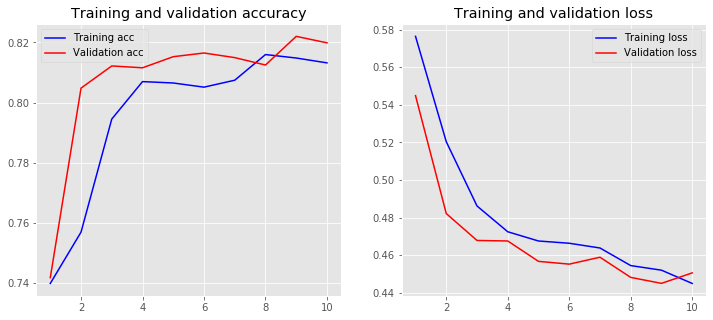

In [35]:
plot_history(history,'/content/drive/My Drive/minor2/twitter2/accuracy and losses graphs(Glove_LSTM).jpg')